# US GP

## To do
- remove y0 intercept NOT DOING - DATA NOT CENTRED AT ZERO
- gridposition as fixed feature?? not for US GP (low downforce)

# Changes
- one hot instead of label
- grouping based on downforce categorisation (low-med and high)
- removal of safety car features
- 

# Prediction Flow

In [1]:
%pip install -q --upgrade numpy scikit-learn fastf1 keras xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import fastf1
import pandas as pd
fastf1.Cache.enable_cache("cache")

In [3]:
def get_weather_data(year,race,session):
    cur_session=fastf1.get_session(year,race,session)
    cur_session.load()
    weather_df=cur_session.weather_data
    weather_data={}
    weather_data["AirTemp"]=weather_df["AirTemp"].mean() # Average Air Temp in degrees Celsius
    weather_data["Humidity"]=weather_df["Humidity"].mean() # Average Humidity in % 
    weather_data["Pressure"]=weather_df["Pressure"].mean() # Average Air pressure in mbar
    weather_data["Rain"]=int(weather_df["Rainfall"].any()) # Check if there was any rainfall
    weather_data["WindSpeed"]=weather_df["WindSpeed"].mean() # Average Wind Speed in m/s
    weather_data["TrackTemp"]=weather_df["TrackTemp"].mean() # Average Track Temperature
    
    return weather_data

In [4]:
# We are not getting clean air race pace. We are getting the BEST pace from practice sessions. After talking to some people in the industry, I realised that
# the pace of the car in clean air might not be a very powerful predictive variable given that for most of the race the track WILL have other cars on it (shocker).

def get_best_race_pace(year, race):
    all_personal_bests = []
    
    for session in ["FP1", "FP2", "FP3"]:
        try:
            cur_session = fastf1.get_session(year, race, session)
            cur_session.load()
            laps = cur_session.laps
            
            laps = laps.drop(columns=['Time', 'DriverNumber', 'LapNumber', 'Stint',
            'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
            'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
            'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
            'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
            'LapStartDate', 'Position', 'DeletedReason',
            'FastF1Generated', 'IsAccurate'])
            # Note that while we are dropping DriverNumber, the 'Driver' column remaining contains abbreviations of the drivers for future mapping.

            laps = laps[(laps['Deleted']==False) & (laps.LapTime.notnull())]
            laps = laps.drop(columns=['Deleted','TrackStatus'])

            # Find Personal Best for this session
            personalbest = laps[laps['IsPersonalBest']==True].copy()
            if not personalbest.empty:
                personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
                personalbest = personalbest.drop(columns=['LapTime'])
                personalbest['Session'] = session  # Track which session
                all_personal_bests.append(personalbest)
                
        except Exception as e:
            print(f"Skipping {session} for {year} {race}: {e}")
            continue
    
    # Combine all sessions
    if all_personal_bests:
        
        combined_bests = pd.concat(all_personal_bests, ignore_index=True)
        
        # Find min lap time per driver across all sessions
        personalbest_map = combined_bests.loc[combined_bests.groupby('Driver')['LapTime (s)'].idxmin()]
        personalbest_map = personalbest_map.reset_index(drop=True)
        personalbest_map
        
        return personalbest_map
    else:
        return pd.DataFrame()  # Empty if no data found

After conferring with people within the domain, I realised that my method of categorising downforce (reverse ranking Hamilton's 2022 top speeds for qualifying sessions) was not very accurate, as it classified Canada as a high downforce circuit when it really is a low downforce circuit. 

To fix this problem, I decided to rely on domain knowledge and used Pirelli's classification of circuits by downforce, which you can find [here](https://f1bythenumbers.com/2019-f1-season-tracks-according-to-pirelli/).

Here is the mapping:

```python
downforce_numeric_mapping = {
    'Australia':4,
    'Bahrain':2,
    'China':2,
    'Baku':2,
    'Spain':4,
    'Monaco':5,
    'Canada':2,
    'Austria':3,
    'Silverstone':4,
    'Hungary':4,
    'Belgium':2,
    'Monza':1,
    'Singapore':5,
    'Japan':3,
    'United States':3,
    'Mexico':4,
    'Brazil':4,
    'Abu Dhabi':3,
    'Saudi Arabia': 2, // From here onwards, Pirelli does not have the classification but I've assigned values based on similar circuits
    'Miami': 2,
    'Imola':4,
    'Netherlands':4
}
```


In [5]:
# Build Model Train Data
# To be used for normalisation
from sklearn.preprocessing import StandardScaler
import logging
from sklearn.preprocessing import LabelEncoder

logging.getLogger('fastf1').setLevel(logging.ERROR) # Truncate fastf1 console logs

train_sessions={2024:['United States'],2025:['Australia','China','Japan','Bahrain','Saudi Arabia','Miami','Imola','Monaco','Spain','Canada','Austria','Silverstone','Belgium','Hungary','Netherlands','Monza','Baku','Singapore']}
train_df=pd.DataFrame()
y=pd.DataFrame()

le_year=LabelEncoder()

for year in train_sessions:
    for race in train_sessions[year]:
        cur_session=fastf1.get_session(year,race,'R') # Get race results for all the races in the list
        cur_session.load()
        print("="*80)
        print(f"Loaded Data for {year} {race}")
        print("="*80)
        cur_results=cur_session.results

        #=====================DROP UNNECESSARY COLUMNS=====================
        cur_results = cur_results.reset_index(drop=True)
        cur_results=cur_results.drop(columns=['DriverNumber', 'BroadcastName', 'DriverId', 'TeamName',
            'TeamColor', 'FirstName', 'LastName', 'FullName',
            'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
            'Q1', 'Q2', 'Q3', 'Status', 'Points'])
        #==================================================================

        cur_results.rename(columns={'Abbreviation':'Driver'},inplace=True)

        #=====================CALCULATE TOTAL RACETIME=====================
        # Get winner's time in seconds
        cur_results.reset_index(drop=True,inplace=True)
        winner_time_seconds = cur_results.iloc[0]['Time'].total_seconds()

        cur_results['Time (s)'] = cur_results['Time'].dt.total_seconds()
        cur_results.loc[1:, 'Time (s)'] = winner_time_seconds + cur_results.loc[1:, 'Time (s)']

        #Winner
        cur_results.loc[0, 'Time (s)'] = winner_time_seconds

        # Deal w Null values
        cur_results['Time (s)'] = cur_results['Time (s)'].fillna(winner_time_seconds + 300)  # +5 minutes penalty
        #==================================================================


        #=====================CALCULATE TOTAL LAP TIME BY SECTOR AVERAGE=====================
        cur_laps = cur_session.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
        cur_laps.dropna(inplace=True)

        # convert lap and sector times to seconds
        for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
            cur_laps[f"{col} (s)"] = cur_laps[col].dt.total_seconds()
            
        # DROPPED SECTOR TOTAL DUE TO PERFECT CORRELATION WITH TARGET VARIABLE

        # # aggregate sector times by driver
        # sector_times = cur_laps.groupby("Driver").agg({
        #     "Sector1Time (s)": "mean",
        #     "Sector2Time (s)": "mean",
        #     "Sector3Time (s)": "mean"
        # }).reset_index()

        # sector_times["TotalSectorTime (s)"] = (
        #     sector_times["Sector1Time (s)"] +
        #     sector_times["Sector2Time (s)"] +
        #     sector_times["Sector3Time (s)"]
        # )

        # cur_results =  cur_results.merge(sector_times[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")

        y = pd.concat([y,cur_laps.groupby("Driver")["LapTime (s)"].mean().reindex(cur_results["Driver"])])
        #======================================================================================


        #=====================FEATURE ENGINEERING=====================

        # Calculate average qualifying position per team and subtract the drivers' quali positions from the mean of their combined grid positions.
        cur_results['Quali_vs_Teammate'] = cur_results.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

        cur_results['Race'] = race
        cur_results['Year'] = year
        #=============================================================


        #=====================GET BEST RACE PACE=====================
        # Get best track race pace across FP1, FP2 and FP3
        best_race_pace=get_best_race_pace(year,race)

        best_race_pace.drop(columns=['IsPersonalBest','Session'],inplace=True)
        pace_mapping=best_race_pace.set_index('Driver')['LapTime (s)']

        cur_results['Best_Pace_seconds'] = cur_results['Driver'].map(pace_mapping)
        #=============================================================


        #=====================MORE FEATURE ENGINEERING=====================
        cur_results['Practice_Gap_to_Fastest'] = cur_results['Best_Pace_seconds'] - cur_results['Best_Pace_seconds'].min()

        cur_results['Practice_vs_Quali_Rank'] = cur_results['Best_Pace_seconds'].rank() - cur_results['GridPosition']

        cur_results['Quali_vs_Teammate'] = cur_results['Quali_vs_Teammate'].fillna(0)
        #==================================================================

        #=====================GET RACE DAY WEATHER DATA=====================
        weather_data=get_weather_data(year,race,'R')
        cur_results = cur_results.assign(**weather_data)
        #===================================================================

        #=====================IS IT USA?=====================
        if race!='United States':
            cur_results['Is_US']=0
        else:
            cur_results['Is_US']=1
        #====================================================

        #=====================MAP DOWNFORCE LEVELS=====================

        downforce_map = {
            'Australia':4,
            'Bahrain':2,
            'China':2,
            'Baku':2,
            'Spain':4,
            'Monaco':5,
            'Canada':2,
            'Austria':3,
            'Silverstone':4,
            'Hungary':4,
            'Belgium':2,
            'Monza':1,
            'Singapore':5,
            'Japan':3,
            'United States':3,
            'Mexico':4,
            'Brazil':4,
            'Abu Dhabi':3,
            'Saudi Arabia': 2,
            'Miami': 2,
            'Imola':4,
            'Netherlands':4
        }
        cur_results['Downforce_Level'] = cur_results['Race'].map(downforce_map)

        #=================================================================

        train_df = pd.concat([train_df, cur_results], ignore_index=True)

print("\n" + "="*80)
print("ENCODING CATEGORICAL VARIABLES")
print("="*80)

# OneHot encode Team (10 teams : 9 dummy variables)
team_dummies = pd.get_dummies(train_df['TeamId'], prefix='Team', drop_first=True)
train_df = pd.concat([train_df, team_dummies], axis=1)
print(f"Team OneHot encoded: {len(team_dummies.columns)} columns")

# OneHot encode Race (19 races : 18 dummy variables)
race_dummies = pd.get_dummies(train_df['Race'], prefix='Race', drop_first=True)
train_df = pd.concat([train_df, race_dummies], axis=1)
print(f"Race OneHot encoded: {len(race_dummies.columns)} columns")

# OneHot encode GridPos (20 teams : 19 dummy variables)
gridpos_dummies = pd.get_dummies(train_df['GridPosition'], prefix='GridPos', drop_first=False)
train_df = pd.concat([train_df, gridpos_dummies], axis=1)
print(f"GridPos OneHot encoded: {len(team_dummies.columns)} columns")

# OneHot encode Driver (20 drivers : 19 dummy variables)
driver_dummies = pd.get_dummies(train_df['Driver'], prefix='Driver', drop_first=False)
train_df = pd.concat([train_df, driver_dummies], axis=1)
print(f"Driver OneHot encoded: {len(driver_dummies.columns)} columns")

# Label encode Year (ordinal: 2024 < 2025) - WILL CONSIDER CHANGING THIS TO NOMINAL BASED ON PERFORMANCE
train_df['Year_encoded'] = le_year.fit_transform(train_df['Year'])

print(f"\nTotal features after encoding: {len(train_df.columns)}")


#-----------------------NO INTERACTION TERMS WITH CATEGORICAL GRIDPOSITION---------------------
# Removed GridPos_x_Downforce and Pace_x_GridPos since GridPosition is now categorical
print("="*80)

Loaded Data for 2024 United States
Skipping FP2 for 2024 United States: Session type 'FP2' does not exist for this event
Skipping FP3 for 2024 United States: Session type 'FP3' does not exist for this event
Loaded Data for 2025 Australia
Loaded Data for 2025 China
Skipping FP2 for 2025 China: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 China: Session type 'FP3' does not exist for this event
Loaded Data for 2025 Japan
Loaded Data for 2025 Bahrain
Loaded Data for 2025 Saudi Arabia
Loaded Data for 2025 Miami
Skipping FP2 for 2025 Miami: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 Miami: Session type 'FP3' does not exist for this event
Loaded Data for 2025 Imola
Loaded Data for 2025 Monaco
Loaded Data for 2025 Spain
Loaded Data for 2025 Canada
Loaded Data for 2025 Austria
Loaded Data for 2025 Silverstone
Loaded Data for 2025 Belgium
Skipping FP2 for 2025 Belgium: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 Bel

In [6]:
train_df

,Driver,TeamId,GridPosition,Time,Laps,Time (s),Quali_vs_Teammate,Race,Year,Best_Pace_seconds,...,Driver_OCO,Driver_PER,Driver_PIA,Driver_RUS,Driver_SAI,Driver_STR,Driver_TSU,Driver_VER,Driver_ZHO,Year_encoded
0,LEC,ferrari,4.0,0 days 01:35:09.639000,56.0,5709.639,0.5,United States,2024,93.623,...,False,False,False,False,False,False,False,False,False,0
1,SAI,ferrari,3.0,0 days 00:00:08.562000,56.0,5718.201,-0.5,United States,2024,93.602,...,False,False,False,False,True,False,False,False,False,0
2,VER,red_bull,2.0,0 days 00:00:19.412000,56.0,5729.051,-3.5,United States,2024,93.855,...,False,False,False,False,False,False,False,True,False,0
3,NOR,mclaren,1.0,0 days 00:00:20.354000,56.0,5729.993,-2.0,United States,2024,93.868,...,False,False,False,False,False,False,False,False,False,0
4,PIA,mclaren,5.0,0 days 00:00:21.921000,56.0,5731.560,2.0,United States,2024,93.908,...,False,False,True,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,COL,alpine,16.0,0 days 00:00:42.890000,61.0,6065.257,-1.5,Singapore,2025,91.047,...,False,False,False,False,False,False,False,False,False,1
375,BOR,sauber,14.0,0 days 00:00:46.753000,61.0,6069.120,1.5,Singapore,2025,90.697,...,False,False,False,False,False,False,False,False,False,1
376,OCO,haas,17.0,0 days 00:00:47.133000,61.0,6069.500,4.0,Singapore,2025,90.784,...,True,False,False,False,False,False,False,False,False,1
377,GAS,alpine,19.0,0 days 00:00:47.461000,61.0,6069.828,1.5,Singapore,2025,91.643,...,False,False,False,False,False,False,False,False,False,1


In [7]:
train_df.columns

Index(['Driver', 'TeamId', 'GridPosition', 'Time', 'Laps', 'Time (s)',
       'Quali_vs_Teammate', 'Race', 'Year', 'Best_Pace_seconds',
       'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 'AirTemp',
       'Humidity', 'Pressure', 'Rain', 'WindSpeed', 'TrackTemp', 'Is_US',
       'Downforce_Level', 'Team_aston_martin', 'Team_ferrari', 'Team_haas',
       'Team_mclaren', 'Team_mercedes', 'Team_rb', 'Team_red_bull',
       'Team_sauber', 'Team_williams', 'Race_Austria', 'Race_Bahrain',
       'Race_Baku', 'Race_Belgium', 'Race_Canada', 'Race_China',
       'Race_Hungary', 'Race_Imola', 'Race_Japan', 'Race_Miami', 'Race_Monaco',
       'Race_Monza', 'Race_Netherlands', 'Race_Saudi Arabia',
       'Race_Silverstone', 'Race_Singapore', 'Race_Spain',
       'Race_United States', 'GridPos_1.0', 'GridPos_2.0', 'GridPos_3.0',
       'GridPos_4.0', 'GridPos_5.0', 'GridPos_6.0', 'GridPos_7.0',
       'GridPos_8.0', 'GridPos_9.0', 'GridPos_10.0', 'GridPos_11.0',
       'GridPos_12.0', 'Grid

In [8]:
#Drop Time, Laps, Time (s), and GridPosition (now using one-hot encoded version)

train_df.drop(columns=['Time', 'Laps', 'Time (s)', 'GridPosition'],inplace=True)
train_df

,Driver,TeamId,Quali_vs_Teammate,Race,Year,Best_Pace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Humidity,...,Driver_OCO,Driver_PER,Driver_PIA,Driver_RUS,Driver_SAI,Driver_STR,Driver_TSU,Driver_VER,Driver_ZHO,Year_encoded
0,LEC,ferrari,0.5,United States,2024,93.623,0.021,-2.0,28.12129,35.535484,...,False,False,False,False,False,False,False,False,False,0
1,SAI,ferrari,-0.5,United States,2024,93.602,0.000,-2.0,28.12129,35.535484,...,False,False,False,False,True,False,False,False,False,0
2,VER,red_bull,-3.5,United States,2024,93.855,0.253,1.0,28.12129,35.535484,...,False,False,False,False,False,False,False,True,False,0
3,NOR,mclaren,-2.0,United States,2024,93.868,0.266,3.0,28.12129,35.535484,...,False,False,False,False,False,False,False,False,False,0
4,PIA,mclaren,2.0,United States,2024,93.908,0.306,0.0,28.12129,35.535484,...,False,False,True,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,COL,alpine,-1.5,Singapore,2025,91.047,0.899,0.0,29.07205,74.360248,...,False,False,False,False,False,False,False,False,False,1
375,BOR,sauber,1.5,Singapore,2025,90.697,0.549,-2.0,29.07205,74.360248,...,False,False,False,False,False,False,False,False,False,1
376,OCO,haas,4.0,Singapore,2025,90.784,0.636,-4.0,29.07205,74.360248,...,True,False,False,False,False,False,False,False,False,1
377,GAS,alpine,1.5,Singapore,2025,91.643,1.495,0.0,29.07205,74.360248,...,False,False,False,False,False,False,False,False,False,1


In [9]:
train_df.to_csv('../data/train_df_usa.csv')

In [10]:
train_df.dtypes

Driver                object
TeamId                object
Quali_vs_Teammate    float64
Race                  object
Year                   int64
                      ...   
Driver_STR              bool
Driver_TSU              bool
Driver_VER              bool
Driver_ZHO              bool
Year_encoded           int64
Length: 89, dtype: object

In [11]:
y


,LapTime (s)
LEC,99.804962
SAI,99.954868
VER,100.156132
NOR,100.106642
PIA,101.173500
...,...
COL,99.213833
BOR,99.251050
OCO,99.233950
GAS,99.224783


In [12]:
train_df.columns

Index(['Driver', 'TeamId', 'Quali_vs_Teammate', 'Race', 'Year',
       'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Humidity', 'Pressure', 'Rain',
       'WindSpeed', 'TrackTemp', 'Is_US', 'Downforce_Level',
       'Team_aston_martin', 'Team_ferrari', 'Team_haas', 'Team_mclaren',
       'Team_mercedes', 'Team_rb', 'Team_red_bull', 'Team_sauber',
       'Team_williams', 'Race_Austria', 'Race_Bahrain', 'Race_Baku',
       'Race_Belgium', 'Race_Canada', 'Race_China', 'Race_Hungary',
       'Race_Imola', 'Race_Japan', 'Race_Miami', 'Race_Monaco', 'Race_Monza',
       'Race_Netherlands', 'Race_Saudi Arabia', 'Race_Silverstone',
       'Race_Singapore', 'Race_Spain', 'Race_United States', 'GridPos_1.0',
       'GridPos_2.0', 'GridPos_3.0', 'GridPos_4.0', 'GridPos_5.0',
       'GridPos_6.0', 'GridPos_7.0', 'GridPos_8.0', 'GridPos_9.0',
       'GridPos_10.0', 'GridPos_11.0', 'GridPos_12.0', 'GridPos_13.0',
       'GridPos_14.0', 'GridPos_15.0', '

TRACK-SPECIFIC MODEL TRAINING

Total data: 365 samples

Low-Medium DF (1-3): 211 samples
High DF (4-5):       154 samples

Categorical/Binary columns: 77
  - Team columns: 9
  - Race columns: 18
  - GridPos columns: 20
  - Driver columns: 25

GROUP 1: LOW-MEDIUM DOWNFORCE TRACKS (DF 1-3)

Train: 168 samples, Test: 43 samples
Best Ridge alpha: 1

--- Linear Regression ---
Train MAE: 0.555s
Test MAE:  1.044s
Test R²:   0.984

--- Ridge Regression ---
Train MAE: 0.572s
Test MAE:  0.923s
Test R²:   0.990

--- 5-Fold Cross Validation ---
Linear - CV MAE: 0.774 ± 0.175
Linear - CV R²:  0.982 ± 0.015
Ridge  - CV MAE: 0.724 ± 0.172
Ridge  - CV R²:  0.984 ± 0.015

GROUP 2: HIGH DOWNFORCE TRACKS (DF 4-5)

Train: 123 samples, Test: 31 samples
Best Ridge alpha: 5

--- Linear Regression ---
Train MAE: 1.135s
Test MAE:  2.928s
Test R²:   0.794

--- Ridge Regression ---
Train MAE: 1.249s
Test MAE:  2.295s
Test R²:   0.807

--- 5-Fold Cross Validation ---
Linear - CV MAE: 2.512 ± 0.404
Linear - CV R²:

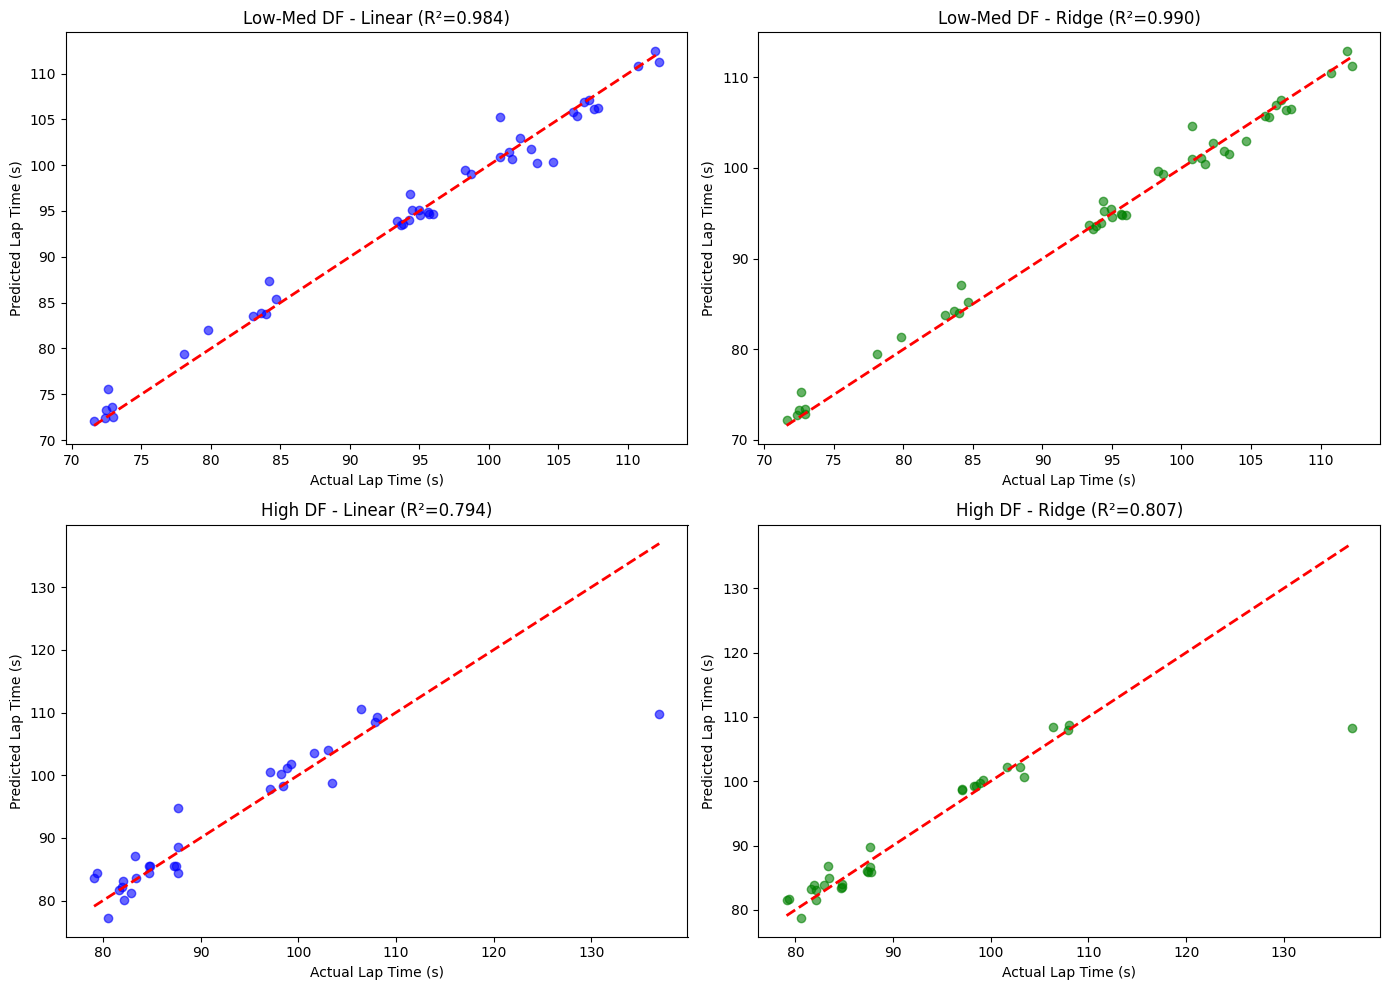


Track-specific training complete! Use appropriate model based on race DF level.


In [13]:
# TRACK-SPECIFIC MODEL TRAINING
# Two groups: Low-Medium DF (1-3) and High DF (4-5)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("="*80)
print("TRACK-SPECIFIC MODEL TRAINING")
print("="*80)
# Prepare data
drivers = train_df['Driver'].copy()
X_init = train_df.drop(columns=['Driver', 'TeamId', 'Race', 'Year'])
X_init = X_init.fillna(0)
# Reset indices
X_reset = X_init.reset_index(drop=True)
y_reset = y.reset_index(drop=True)
drivers_reset = drivers.reset_index(drop=True)
# Remove NaN values
valid_indices = y_reset.notna().squeeze()
X_clean = X_reset[valid_indices]
y_clean = y_reset[valid_indices]
drivers_clean = drivers_reset[valid_indices]
print(f"\nTotal data: {len(X_clean)} samples")
# Define track groups based on Downforce Level
# Boolean masks are created for easier data filtering (similar to image masking techniques)
low_med_df_mask = X_clean['Downforce_Level'] <= 3
high_df_mask = X_clean['Downforce_Level'] >= 4
# Split data by track group
X_low_med = X_clean[low_med_df_mask].copy()
y_low_med = y_clean[low_med_df_mask].copy()
drivers_low_med = drivers_clean[low_med_df_mask].copy()
X_high = X_clean[high_df_mask].copy()
y_high = y_clean[high_df_mask].copy()
drivers_high = drivers_clean[high_df_mask].copy()
print(f"\nLow-Medium DF (1-3): {len(X_low_med)} samples")
print(f"High DF (4-5):       {len(X_high)} samples")
# Define categorical columns (binary/ordinal - won't be normalised)
categorical_columns = ['Year_encoded', 'Is_US', 'Downforce_Level', 'Rain','Year']
# OneHot columns are also treated as categorical (they're already 0/1)
team_columns = [col for col in X_clean.columns if col.startswith('Team_')]
race_columns = [col for col in X_clean.columns if col.startswith('Race_')]
gridpos_columns = [col for col in X_clean.columns if col.startswith('GridPos_')]
driver_columns = [col for col in X_clean.columns if col.startswith('Driver_')]
categorical_columns.extend(team_columns)
categorical_columns.extend(race_columns)
categorical_columns.extend(gridpos_columns)
categorical_columns.extend(driver_columns)  
# CRITICAL: Driver is categorical
print(f"\nCategorical/Binary columns: {len(categorical_columns)}")
print(f"  - Team columns: {len(team_columns)}")
print(f"  - Race columns: {len(race_columns)}")
print(f"  - GridPos columns: {len(gridpos_columns)}")
print(f"  - Driver columns: {len(driver_columns)}")
# Store models
models = {}

# ============================================================================
# GROUP 1: LOW-MEDIUM DOWNFORCE (1-3)
# ============================================================================
print("\n" + "="*80)
print("GROUP 1: LOW-MEDIUM DOWNFORCE TRACKS (DF 1-3)")
print("="*80)

# Identify continuous columns
continuous_columns = [col for col in X_low_med.columns if col not in categorical_columns]

# Normalize
scaler_low_med = StandardScaler().fit(X_low_med[continuous_columns])
X_low_med_norm = X_low_med.copy()
X_low_med_norm[continuous_columns] = scaler_low_med.transform(X_low_med[continuous_columns])

# Train-test split
X_train_lm, X_test_lm, y_train_lm, y_test_lm = train_test_split(
    X_low_med_norm, y_low_med, test_size=0.2, random_state=42
)

print(f"\nTrain: {len(X_train_lm)} samples, Test: {len(X_test_lm)} samples")

# Train Linear Regression
lr_model_lm = LinearRegression()
lr_model_lm.fit(X_train_lm, y_train_lm)

# Train Ridge with GridSearchCV
param_grid = {'alpha': [0.1, 1, 5, 10, 20, 50, 100]}
ridge_grid_lm = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2', n_jobs=-1)
ridge_grid_lm.fit(X_train_lm, y_train_lm)
ridge_model_lm = ridge_grid_lm.best_estimator_

print(f"Best Ridge alpha: {ridge_grid_lm.best_params_['alpha']}")

# Predictions
lr_train_pred_lm = lr_model_lm.predict(X_train_lm)
lr_test_pred_lm = lr_model_lm.predict(X_test_lm)
ridge_train_pred_lm = ridge_model_lm.predict(X_train_lm)
ridge_test_pred_lm = ridge_model_lm.predict(X_test_lm)

# Evaluation
print("\n--- Linear Regression ---")
print(f"Train MAE: {mean_absolute_error(y_train_lm, lr_train_pred_lm):.3f}s")
print(f"Test MAE:  {mean_absolute_error(y_test_lm, lr_test_pred_lm):.3f}s")
print(f"Test R²:   {r2_score(y_test_lm, lr_test_pred_lm):.3f}")

print("\n--- Ridge Regression ---")
print(f"Train MAE: {mean_absolute_error(y_train_lm, ridge_train_pred_lm):.3f}s")
print(f"Test MAE:  {mean_absolute_error(y_test_lm, ridge_test_pred_lm):.3f}s")
print(f"Test R²:   {r2_score(y_test_lm, ridge_test_pred_lm):.3f}")
# 5-Fold Cross Validation
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['neg_mean_absolute_error', 'r2']

lr_cv_lm = cross_validate(lr_model_lm, X_low_med_norm, y_low_med.squeeze(),
                          cv=cv_folds, scoring=scoring)
ridge_cv_lm = cross_validate(ridge_model_lm, X_low_med_norm, y_low_med.squeeze(),
                             cv=cv_folds, scoring=scoring)

print("\n--- 5-Fold Cross Validation ---")
print(f"Linear - CV MAE: {-lr_cv_lm['test_neg_mean_absolute_error'].mean():.3f} ± {lr_cv_lm['test_neg_mean_absolute_error'].std():.3f}")
print(f"Linear - CV R²:  {lr_cv_lm['test_r2'].mean():.3f} ± {lr_cv_lm['test_r2'].std():.3f}")
print(f"Ridge  - CV MAE: {-ridge_cv_lm['test_neg_mean_absolute_error'].mean():.3f} ± {ridge_cv_lm['test_neg_mean_absolute_error'].std():.3f}")
print(f"Ridge  - CV R²:  {ridge_cv_lm['test_r2'].mean():.3f} ± {ridge_cv_lm['test_r2'].std():.3f}")
# Store models
models['low_med_df'] = {
    'linear': lr_model_lm,
    'ridge': ridge_model_lm,
    'scaler': scaler_low_med,
    'downforce_range': (1, 3),
    'team_columns': team_columns,
    'race_columns': race_columns,
    'gridpos_columns': gridpos_columns,
    'driver_columns': driver_columns
}

# ============================================================================
# GROUP 2: HIGH DOWNFORCE (4-5)
# ============================================================================
print("\n" + "="*80)
print("GROUP 2: HIGH DOWNFORCE TRACKS (DF 4-5)")
print("="*80)

# Normalize
scaler_high = StandardScaler().fit(X_high[continuous_columns])
X_high_norm = X_high.copy()
X_high_norm[continuous_columns] = scaler_high.transform(X_high[continuous_columns])

# Train-test split
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_high_norm, y_high, test_size=0.2, random_state=42
)

print(f"\nTrain: {len(X_train_h)} samples, Test: {len(X_test_h)} samples")

# Train Linear Regression
lr_model_h = LinearRegression()
lr_model_h.fit(X_train_h, y_train_h)

# Train Ridge with GridSearchCV
ridge_grid_h = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2', n_jobs=-1)
ridge_grid_h.fit(X_train_h, y_train_h)
ridge_model_h = ridge_grid_h.best_estimator_

print(f"Best Ridge alpha: {ridge_grid_h.best_params_['alpha']}")

# Predictions
lr_train_pred_h = lr_model_h.predict(X_train_h)
lr_test_pred_h = lr_model_h.predict(X_test_h)
ridge_train_pred_h = ridge_model_h.predict(X_train_h)
ridge_test_pred_h = ridge_model_h.predict(X_test_h)

# Evaluation
print("\n--- Linear Regression ---")
print(f"Train MAE: {mean_absolute_error(y_train_h, lr_train_pred_h):.3f}s")
print(f"Test MAE:  {mean_absolute_error(y_test_h, lr_test_pred_h):.3f}s")
print(f"Test R²:   {r2_score(y_test_h, lr_test_pred_h):.3f}")

print("\n--- Ridge Regression ---")
print(f"Train MAE: {mean_absolute_error(y_train_h, ridge_train_pred_h):.3f}s")
print(f"Test MAE:  {mean_absolute_error(y_test_h, ridge_test_pred_h):.3f}s")
print(f"Test R²:   {r2_score(y_test_h, ridge_test_pred_h):.3f}")

# 5-Fold Cross Validation
lr_cv_h = cross_validate(lr_model_h, X_high_norm, y_high.squeeze(),
                         cv=cv_folds, scoring=scoring)
ridge_cv_h = cross_validate(ridge_model_h, X_high_norm, y_high.squeeze(),
                            cv=cv_folds, scoring=scoring)

print("\n--- 5-Fold Cross Validation ---")
print(f"Linear - CV MAE: {-lr_cv_h['test_neg_mean_absolute_error'].mean():.3f} ± {lr_cv_h['test_neg_mean_absolute_error'].std():.3f}")
print(f"Linear - CV R²:  {lr_cv_h['test_r2'].mean():.3f} ± {lr_cv_h['test_r2'].std():.3f}")
print(f"Ridge  - CV MAE: {-ridge_cv_h['test_neg_mean_absolute_error'].mean():.3f} ± {ridge_cv_h['test_neg_mean_absolute_error'].std():.3f}")
print(f"Ridge  - CV R²:  {ridge_cv_h['test_r2'].mean():.3f} ± {ridge_cv_h['test_r2'].std():.3f}")

# Store models
models['high_df'] = {
    'linear': lr_model_h,
    'ridge': ridge_model_h,
    'scaler': scaler_high,
    'downforce_range': (4, 5),
    'team_columns': team_columns,
    'race_columns': race_columns,
    'gridpos_columns': gridpos_columns,
    'driver_columns': driver_columns,
}

# ============================================================================
# SUMMARY COMPARISON
# ============================================================================
print("\n" + "="*80)
print("SUMMARY: Track-Specific vs Single Model Performance")
print("="*80)

print("\n┌─────────────────────────┬──────────────┬──────────────┬──────────────┐")
print("│ Track Group             │ Test R² (LR) │ Test R² (R)  │ CV R² (R)    │")
print("├─────────────────────────┼──────────────┼──────────────┼──────────────┤")
print(f"│ Low-Med DF (1-3)        │    {r2_score(y_test_lm, lr_test_pred_lm):.3f}     │    {r2_score(y_test_lm, ridge_test_pred_lm):.3f}     │    {ridge_cv_lm['test_r2'].mean():.3f}     │")
print(f"│ High DF (4-5)           │    {r2_score(y_test_h, lr_test_pred_h):.3f}     │    {r2_score(y_test_h, ridge_test_pred_h):.3f}     │    {ridge_cv_h['test_r2'].mean():.3f}     │")
print("└─────────────────────────┴──────────────┴──────────────┴──────────────┘")

print("\nModels saved in 'models' dict:")

print("   - models['low_med_df']['ridge'] → for tracks with DF 1-3")
print("   - models['high_df']['ridge'] → for tracks with DF 4-5")
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Low-Med DF - Linear
axes[0, 0].scatter(y_test_lm, lr_test_pred_lm, alpha=0.6, color='blue')
axes[0, 0].plot([y_test_lm.min(), y_test_lm.max()], [y_test_lm.min(), y_test_lm.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Lap Time (s)')
axes[0, 0].set_ylabel('Predicted Lap Time (s)')
axes[0, 0].set_title(f'Low-Med DF - Linear (R²={r2_score(y_test_lm, lr_test_pred_lm):.3f})')


# Low-Med DF - Ridge
axes[0, 1].scatter(y_test_lm, ridge_test_pred_lm, alpha=0.6, color='green')
axes[0, 1].plot([y_test_lm.min(), y_test_lm.max()], [y_test_lm.min(), y_test_lm.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Lap Time (s)')
axes[0, 1].set_ylabel('Predicted Lap Time (s)')
axes[0, 1].set_title(f'Low-Med DF - Ridge (R²={r2_score(y_test_lm, ridge_test_pred_lm):.3f})')

# High DF - Linear
axes[1, 0].scatter(y_test_h, lr_test_pred_h, alpha=0.6, color='blue')
axes[1, 0].plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Lap Time (s)')
axes[1, 0].set_ylabel('Predicted Lap Time (s)')
axes[1, 0].set_title(f'High DF - Linear (R²={r2_score(y_test_h, lr_test_pred_h):.3f})')

# High DF - Ridge
axes[1, 1].scatter(y_test_h, ridge_test_pred_h, alpha=0.6, color='green')
axes[1, 1].plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Lap Time (s)')
axes[1, 1].set_ylabel('Predicted Lap Time (s)')
axes[1, 1].set_title(f'High DF - Ridge (R²={r2_score(y_test_h, ridge_test_pred_h):.3f})')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Track-specific training complete! Use appropriate model based on race DF level.")
print("="*80)

In [14]:
X_train_lm

,Quali_vs_Teammate,Best_Pace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Humidity,Pressure,Rain,WindSpeed,TrackTemp,...,Driver_OCO,Driver_PER,Driver_PIA,Driver_RUS,Driver_SAI,Driver_STR,Driver_TSU,Driver_VER,Driver_ZHO,Year_encoded
210,2.599573,-1.402024,0.274468,0.188302,-0.103657,-1.085339,0.830768,1,-1.172791,1.330666,...,False,False,False,False,False,False,True,False,False,1
131,-1.628490,0.088370,1.758453,1.852461,0.408387,0.645843,0.532794,1,-1.150090,0.234655,...,True,False,False,False,False,False,False,False,False,1
90,0.322924,0.276321,-0.406438,-0.019718,0.505154,-0.228095,0.345412,0,1.446657,-0.473042,...,False,False,False,False,False,False,False,False,False,1
105,0.322924,0.042483,0.355917,1.020382,0.995931,0.631280,0.284349,0,-1.201410,0.144289,...,False,False,False,False,False,False,False,False,False,1
120,0.322924,-0.099857,-1.582548,-0.643777,0.408387,0.645843,0.532794,1,-1.150090,0.234655,...,False,False,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,1.461248,-0.005606,0.090396,-0.435757,0.408387,0.645843,0.532794,1,-1.150090,0.234655,...,False,False,False,False,False,False,True,False,False,1
14,0.973395,0.587615,0.074106,0.396322,0.720894,-0.711902,0.272795,0,-0.038953,1.055554,...,False,False,False,False,False,True,False,False,False,0
113,0.648159,0.102778,1.426145,-0.227737,0.995931,0.631280,0.284349,0,-1.201410,0.144289,...,True,False,False,False,False,False,False,False,False,1
325,0.160306,-0.779711,-0.948882,-0.851797,0.446328,-0.362708,-0.165541,0,1.090325,0.711712,...,False,False,False,False,False,False,False,False,False,1


In [15]:
X_train_lm.columns

Index(['Quali_vs_Teammate', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Humidity', 'Pressure', 'Rain',
       'WindSpeed', 'TrackTemp', 'Is_US', 'Downforce_Level',
       'Team_aston_martin', 'Team_ferrari', 'Team_haas', 'Team_mclaren',
       'Team_mercedes', 'Team_rb', 'Team_red_bull', 'Team_sauber',
       'Team_williams', 'Race_Austria', 'Race_Bahrain', 'Race_Baku',
       'Race_Belgium', 'Race_Canada', 'Race_China', 'Race_Hungary',
       'Race_Imola', 'Race_Japan', 'Race_Miami', 'Race_Monaco', 'Race_Monza',
       'Race_Netherlands', 'Race_Saudi Arabia', 'Race_Silverstone',
       'Race_Singapore', 'Race_Spain', 'Race_United States', 'GridPos_1.0',
       'GridPos_2.0', 'GridPos_3.0', 'GridPos_4.0', 'GridPos_5.0',
       'GridPos_6.0', 'GridPos_7.0', 'GridPos_8.0', 'GridPos_9.0',
       'GridPos_10.0', 'GridPos_11.0', 'GridPos_12.0', 'GridPos_13.0',
       'GridPos_14.0', 'GridPos_15.0', 'GridPos_16.0', 'GridPos_17.0',
       'Grid

In [16]:
#----------------CREATE PREDICTION DATASET-----------------

predict_df = pd.DataFrame()
predict_df['Abbreviation'] = ['PIA','NOR','HAM','LEC','RUS','ANT','LAW','HAD','SAI','ALB','VER','TSU','ALO','STR','BEA','OCO','BOR','HUL','GAS','COL']

# Create driver to team mapping (2025 season)
driver_to_team = {
    'PIA': 'mclaren',
    'NOR': 'mclaren', 
    'HAM': 'ferrari',       
    'LEC': 'ferrari',
    'RUS': 'mercedes',
    'ANT': 'mercedes',      
    'LAW': 'rb',           
    'HAD': 'rb',
    'SAI': 'williams',       
    'ALB': 'williams',
    'VER': 'red_bull',
    'TSU': 'red_bull',           
    'ALO': 'aston_martin',
    'STR': 'aston_martin',
    'BEA': 'haas',          
    'OCO': 'haas',
    'BOR': 'sauber',       
    'HUL': 'sauber',
    'GAS': 'alpine',
    'COL': 'alpine'    
}

predict_df['TeamId'] = predict_df['Abbreviation'].map(driver_to_team)

# Grid positions for US GP
grid_positions = {
    'VER': 1.0,
    'NOR': 2.0, 
    'LEC': 3.0,
    'RUS': 4.0,
    'HAM': 5.0,
    'PIA': 6.0,       
    'ANT': 7.0,          
    'BEA': 8.0,
    'SAI': 9.0,    
    'ALO': 10.0,
    'HUL': 11.0,            
    'LAW': 12.0,
    'TSU': 13.0,
    'GAS': 14.0,          
    'COL': 15.0,
    'BOR': 16.0,       
    'OCO': 17.0,
    'ALB': 18.0,
    'HAD': 19.0,  
    'STR': 20.0
}

predict_df['GridPosition'] = predict_df['Abbreviation'].map(grid_positions)
predict_df['Quali_vs_Teammate'] = predict_df.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

predict_df['Race'] = 'United States'
predict_df['Year'] = 2025

# Get practice pace data (will need FP1, FP2, FP3 data from race weekend)
best_race_pace = get_best_race_pace(2025, 'United States')
best_race_pace.drop(columns=['IsPersonalBest','Session'], inplace=True)
pace_mapping = best_race_pace.set_index('Driver')['LapTime (s)']
predict_df['Best_Pace_seconds'] = predict_df['Abbreviation'].map(pace_mapping)
        
predict_df['Practice_Gap_to_Fastest'] = predict_df['Best_Pace_seconds'] - predict_df['Best_Pace_seconds'].min()
predict_df['Practice_vs_Quali_Rank'] = predict_df['Best_Pace_seconds'].rank() - predict_df['GridPosition']
predict_df['Quali_vs_Teammate'] = predict_df['Quali_vs_Teammate'].fillna(0)

# Weather data for US GP race day
predict_df['AirTemp'] = 31.000000
predict_df['Humidity'] = 65.000000
predict_df['Pressure'] = 1013.000000
predict_df['Rain'] = 0
predict_df['WindSpeed'] = 15.000000
predict_df['TrackTemp'] = 45.000000

# Is US GP
predict_df['Is_US'] = 1

# Add Downforce Level (United States is medium downforce = 3)
predict_df['Downforce_Level'] = 3

# Label encode Year (using the same encoder from training)
predict_df['Year_encoded'] = le_year.transform(predict_df['Year'])

# ====== CRITICAL: ONE-HOT ENCODE GRIDPOSITION =======
# Must match the training encoding
grid_dummies_pred = pd.get_dummies(predict_df['GridPosition'], prefix='GridPos', drop_first=False)
predict_df = pd.concat([predict_df, grid_dummies_pred], axis=1)

# Add missing GridPos columns with False values (positions not in this race)
for col in models['low_med_df']['gridpos_columns']:
    if col not in predict_df.columns:
        predict_df[col] = False

# OneHot encode Team
team_dummies_pred = pd.get_dummies(predict_df['TeamId'], prefix='Team', drop_first=True)
predict_df = pd.concat([predict_df, team_dummies_pred], axis=1)

# OneHot encode Race
race_dummies_pred = pd.get_dummies(predict_df['Race'], prefix='Race', drop_first=True)
predict_df = pd.concat([predict_df, race_dummies_pred], axis=1)

# Rename Driver column first (before OneHot encoding)
predict_df.rename(columns={'Abbreviation': 'Driver'}, inplace=True)

# OneHot encode Driver
driver_dummies_pred = pd.get_dummies(predict_df['Driver'], prefix='Driver', drop_first=False)
predict_df = pd.concat([predict_df, driver_dummies_pred], axis=1)

# Add missing Driver columns with False values (if any drivers weren't in prediction data)
for col in models['low_med_df']['driver_columns']:
    if col not in predict_df.columns:
        predict_df[col] = False

# Add missing team columns with False values (if any teams weren't in prediction data)
for col in models['low_med_df']['team_columns']:
    if col not in predict_df.columns:
        predict_df[col] = False

# Add missing race columns with False values (if any races weren't in prediction data)
for col in models['low_med_df']['race_columns']:
    if col not in predict_df.columns:
        predict_df[col] = False
        
# Set Race_United States to True (since this is US GP prediction)
if 'Race_United States' in predict_df.columns:
    predict_df['Race_United States'] = True

# Create final prediction features - NO GridPosition, NO interaction terms
feature_columns = ['Quali_vs_Teammate', 'Best_Pace_seconds',
                   'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 'AirTemp',
                   'Humidity', 'Pressure', 'Rain', 'WindSpeed', 'TrackTemp', 'Is_US',
                   'Downforce_Level', 'Year_encoded']

# Add all team, race, gridpos, and driver columns
feature_columns.extend(models['low_med_df']['team_columns'])
feature_columns.extend(models['low_med_df']['race_columns'])
feature_columns.extend(models['low_med_df']['gridpos_columns'])
feature_columns.extend(models['low_med_df']['driver_columns'])

# Select features in the same order as training (keep Driver and GridPosition for display only)
driver_names = predict_df['Driver'].copy()
X_predict = predict_df[feature_columns].copy()
X_predict.insert(0, 'GridPosition', predict_df['GridPosition'])
X_predict.insert(0, 'Driver', driver_names)

print("Prediction dataset created successfully!")
print(f"Shape: {X_predict.shape}")
print(f"\nFirst few rows:")
print(X_predict.head())

Skipping FP2 for 2025 United States: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 United States: Session type 'FP3' does not exist for this event
Prediction dataset created successfully!
Shape: (20, 87)

First few rows:
  Driver  GridPosition  Quali_vs_Teammate  Best_Pace_seconds  \
0    PIA           6.0                2.0             93.573   
1    NOR           2.0               -2.0             93.294   
2    HAM           5.0                1.0             93.965   
3    LEC           3.0               -1.0             96.080   
4    RUS           4.0               -1.5             93.931   

   Practice_Gap_to_Fastest  Practice_vs_Quali_Rank  AirTemp  Humidity  \
0                    0.279                    -3.0     31.0      65.0   
1                    0.000                    -1.0     31.0      65.0   
2                    0.671                     3.0     31.0      65.0   
3                    2.786                    17.0     31.0      65.0   
4   

In [27]:
# Make Predictions - Using Track-Specific Model (Low-Med DF Ridge)

print("="*80)
print("US GP 2025 RACE PREDICTION")
print("="*80)

# US GP has DF=3, so use low-med DF model
track_downforce = 3
selected_model = models['low_med_df']['ridge']
selected_scaler = models['low_med_df']['scaler']

print(f"\nUsing Low-Medium DF Ridge model")
print(f"Track downforce level: {track_downforce}")

# Get exact feature names and order from the trained model
model_features = selected_model.feature_names_in_
print(f"Model expects {len(model_features)} features")

# Reorder prediction data to match model's expected feature order
X_for_prediction = X_predict.drop(columns=['Driver'])[model_features].copy()

print(f"Prediction data shape: {X_for_prediction.shape}")

# Normalize continuous features (same as training)
categorical_cols = ['Year_encoded', 'Is_US', 'Downforce_Level', 'Rain']
categorical_cols.extend([c for c in model_features if c.startswith('Team_')])
categorical_cols.extend([c for c in model_features if c.startswith('Race_')])
categorical_cols.extend([c for c in model_features if c.startswith('GridPos_')])
categorical_cols.extend([c for c in model_features if c.startswith('Driver_')])
continuous_cols = [c for c in model_features if c not in categorical_cols]

X_normalized = X_for_prediction.copy()
X_normalized[continuous_cols] = selected_scaler.transform(X_for_prediction[continuous_cols])

# Make predictions
predictions = selected_model.predict(X_normalized)

print("\n" + "="*80)
print("PREDICTIONS")
print("="*80)

results = pd.DataFrame({
    'Driver': X_predict['Driver'],
    'Grid': X_predict['GridPosition'],
    'Predicted_LapTime': predictions.flatten()
}).sort_values('Predicted_LapTime')

print("\n 🇺🇸 PREDICTED 2025 US GP PODIUM 🇺🇸 ")
print("="*35)
print(f"🥇 P1: {results.iloc[0]['Driver']}  {results.iloc[0]['Predicted_LapTime']:.3f}s")
print(f"🥈 P2: {results.iloc[1]['Driver']}  {results.iloc[1]['Predicted_LapTime']:.3f}s")
print(f"🥉 P3: {results.iloc[2]['Driver']}  {results.iloc[2]['Predicted_LapTime']:.3f}s")
print("="*35)
# (Grid P{int(results.iloc[1]['Grid'])}) - 
print("\n" + "="*60)
print("FULL RESULTS")
print("="*60)
results.reset_index(drop=True, inplace=True)
results.index = results.index + 1
print(results[['Driver', 'Grid', 'Predicted_LapTime']])



US GP 2025 RACE PREDICTION

Using Low-Medium DF Ridge model
Track downforce level: 3
Model expects 85 features
Prediction data shape: (20, 85)

PREDICTIONS

 🇺🇸 PREDICTED 2025 US GP PODIUM 🇺🇸 
🥇 P1: NOR  137.069s
🥈 P2: VER  137.482s
🥉 P3: HAM  137.585s

FULL RESULTS
   Driver  Grid  Predicted_LapTime
1     NOR   2.0         137.069362
2     VER   1.0         137.481896
3     HAM   5.0         137.585383
4     PIA   6.0         137.597215
5     RUS   4.0         137.805328
6     ANT   7.0         137.948784
7     HUL  11.0         138.238785
8     LEC   3.0         138.348381
9     GAS  14.0         138.490829
10    HAD  19.0         138.595446
11    BOR  16.0         138.740541
12    STR  20.0         138.776879
13    BEA   8.0         138.832269
14    OCO  17.0         138.949536
15    ALB  18.0         139.088339
16    SAI   9.0         139.188347
17    COL  15.0         139.425291
18    LAW  12.0         139.477891
19    ALO  10.0         139.709233
20    TSU  13.0         141.21687

In [18]:
X_normalized

,Quali_vs_Teammate,Best_Pace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Humidity,Pressure,Rain,WindSpeed,TrackTemp,...,Driver_OCO,Driver_PER,Driver_PIA,Driver_RUS,Driver_SAI,Driver_STR,Driver_TSU,Driver_VER,Driver_ZHO,Year_encoded
0,0.648159,0.491620,-1.128068,-0.643777,1.301991,0.743648,0.564425,0,33.072919,0.889333,...,False,False,True,False,False,False,False,False,False,1
1,-0.652783,0.466015,-1.582548,-0.227737,1.301991,0.743648,0.564425,0,33.072919,0.889333,...,False,False,False,False,False,False,False,False,False,1
2,0.322924,0.527595,-0.489515,0.604342,1.301991,0.743648,0.564425,0,33.072919,0.889333,...,False,False,False,False,False,False,False,False,False,1
3,-0.327548,0.721695,2.955740,3.516620,1.301991,0.743648,0.564425,0,33.072919,0.889333,...,False,False,False,False,False,False,False,False,False,1
4,-0.490166,0.524475,-0.544899,0.604342,1.301991,0.743648,0.564425,0,33.072919,0.889333,...,False,False,False,True,False,False,False,False,False,1
5,0.485541,0.598444,0.768044,2.268501,1.301991,0.743648,0.564425,0,33.072919,0.889333,...,False,False,False,False,False,False,False,False,False,1
6,-1.140637,0.587615,0.575826,0.604342,1.301991,0.743648,0.564425,0,33.072919,0.889333,...,False,False,False,False,False,False,False,False,False,1
7,1.136013,0.545032,-0.180012,-2.099916,1.301991,0.743648,0.564425,0,33.072919,0.889333,...,False,False,False,False,False,False,False,False,False,1
8,-1.465873,0.702790,2.620174,2.060481,1.301991,0.743648,0.564425,0,33.072919,0.889333,...,False,False,False,False,True,False,False,False,False,1
9,1.461248,0.523465,-0.562818,-2.515955,1.301991,0.743648,0.564425,0,33.072919,0.889333,...,False,False,False,False,False,False,False,False,False,1


In [19]:
predict_df[['Driver', 'GridPosition', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest']].sort_values('GridPosition')

,Driver,GridPosition,Best_Pace_seconds,Practice_Gap_to_Fastest
10,VER,1.0,93.648,0.354
1,NOR,2.0,93.294,0.000
3,LEC,3.0,96.080,2.786
4,RUS,4.0,93.931,0.637
2,HAM,5.0,93.965,0.671
0,PIA,6.0,93.573,0.279
5,ANT,7.0,94.737,1.443
14,BEA,8.0,94.333,1.039
8,SAI,9.0,95.874,2.580
12,ALO,10.0,93.639,0.345


In [20]:
X_normalized.columns

Index(['Quali_vs_Teammate', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Humidity', 'Pressure', 'Rain',
       'WindSpeed', 'TrackTemp', 'Is_US', 'Downforce_Level',
       'Team_aston_martin', 'Team_ferrari', 'Team_haas', 'Team_mclaren',
       'Team_mercedes', 'Team_rb', 'Team_red_bull', 'Team_sauber',
       'Team_williams', 'Race_Austria', 'Race_Bahrain', 'Race_Baku',
       'Race_Belgium', 'Race_Canada', 'Race_China', 'Race_Hungary',
       'Race_Imola', 'Race_Japan', 'Race_Miami', 'Race_Monaco', 'Race_Monza',
       'Race_Netherlands', 'Race_Saudi Arabia', 'Race_Silverstone',
       'Race_Singapore', 'Race_Spain', 'Race_United States', 'GridPos_1.0',
       'GridPos_2.0', 'GridPos_3.0', 'GridPos_4.0', 'GridPos_5.0',
       'GridPos_6.0', 'GridPos_7.0', 'GridPos_8.0', 'GridPos_9.0',
       'GridPos_10.0', 'GridPos_11.0', 'GridPos_12.0', 'GridPos_13.0',
       'GridPos_14.0', 'GridPos_15.0', 'GridPos_16.0', 'GridPos_17.0',
       'Grid

In [23]:
ridge_model_lm.coef_

array([-0.01429862,  8.45503694,  0.01942788, -0.31102359,  0.97528391,
        0.85233153,  0.20424295,  1.90029406,  1.09807398, -1.78390136,
        1.36932984,  0.43774267,  0.33819342, -0.60591487, -0.18763357,
       -0.46318797, -0.20178444,  0.05202348, -0.18531441, -0.39756258,
        0.24855095, -1.15786042,  1.60508044,  0.06957818,  2.16913023,
        0.04348453,  0.38636094,  0.        ,  0.        , -2.18397376,
       -0.3123207 ,  0.        , -2.41024701,  0.        ,  0.42143773,
        0.        ,  0.        ,  0.        ,  1.36932984, -0.11793017,
       -0.13114468,  0.01689074, -0.14413119, -0.01640603, -0.16908823,
       -0.14266558,  0.49565218, -0.22519326, -0.10099921, -0.36341755,
        0.68617802,  2.24491889, -0.2629854 ,  0.05527778, -0.06929574,
       -0.29769825, -0.45366577, -0.58676995, -0.4175266 ,  0.0963104 ,
        0.84584334, -0.08958457, -0.14249581,  0.06791161,  0.        ,
        0.40339118,  0.22585621, -0.09775116, -0.13198721, -0.07